#Proyecto Módulo 5 - Redes Neuronales

###Presentado por:
* Sebastian Rendón Patiño
* Andrés Felipe Aristizábal Miranda

---
Conjunto de datos.
[Chest X-Ray Images (Pneumonia) with new class](https://www.kaggle.com/datasets/ahmedhaytham/chest-xray-images-pneumonia-with-new-class?rvi=1)

In [1]:
!wget --no-cache -O x-rays.zip.npy -q "https://drive.google.com/uc?export=download&id=1It4NYRJNEem3YLHJqYZyclUbR85eqZH8"

In [2]:
!pip install opencv-python

In [3]:
import os
import pdb
import random
from glob import glob

import cv2
from cv2.gapi import RGB2Gray

import numpy as np
import pandas as pd
import sklearn
from tqdm import tqdm
import matplotlib.pyplot as plt
import skimage
from skimage.transform import resize
from skimage.color import rgb2gray

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, save_model, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import zipfile

# Ruta al archivo .zip que deseas descomprimir
archivo_zip = '/content/drive/MyDrive/Colab Notebooks/Cursos/UNAL/x-rays.zip'

# Directorio de destino donde se descomprimirán los archivos (la misma carpeta)
directorio_destino = '/content/'

# Abre el archivo .zip
with zipfile.ZipFile(archivo_zip, 'r') as zip_ref:
    # Extrae todos los archivos en el directorio de destino
    zip_ref.extractall(directorio_destino)

print(f'Archivos descomprimidos en: {directorio_destino}')

Archivos descomprimidos en: /content/


In [6]:
files = os.listdir("./Data_blance")

# Imprimir el contenido de la carpeta

for file in files:
    print(file)

Train
Test
Val


In [7]:
train_dir = "Data_blance/Train"
test_dir = "Data_blance/Test"
val_dir = "Data_blance/Val"

load_from_images = True

def get_data(folder):
    X = []
    y = []
    for folderName in os.listdir(folder):
        if not folderName.startswith('.'):
            if folderName in ['bacteria']:
                label = 0
            elif folderName in ['Normal']:
                label = 1
            elif folderName in ['virus']:
                label = 2
            else:
                label = 3
            for image_filename in tqdm(os.listdir(folder + '/' + folderName)):
                img_file = cv2.imread(folder + '/' + folderName + '/' + image_filename)
                if img_file is not None:
                    img_file = skimage.transform.resize(img_file, (150, 150, 3), mode='constant')
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
    X = np.asarray(X)
    y = np.asarray(y)

    return X, y

if load_from_images:
    X_train, y_train = get_data(train_dir)
    X_test, y_test = get_data(test_dir)
    X_val, y_val = get_data(val_dir)

    np.save('xtrain.npy', X_train)
    np.save('ytrain', y_train)
    np.save('xtest.npy', X_test)
    np.save('ytest', y_test)
    np.save('xval.npy', X_val)
    np.save('yval', y_val)
else:
    X_train = np.load('xtrain.npy')
    y_train = np.load('ytrain.npy')
    X_test = np.load('xtest.npy')
    y_test = np.load('ytest.npy')
    X_val = np.load('xval.npy')
    y_val = np.load('yval.npy')

 67%|██████▋   | 876/1300 [08:22<04:03,  1.74it/s]


KeyboardInterrupt: ignored

In [ ]:
multiple_images = glob("./Data_blance/Train/Normal/**")
def plot_three_images(images):
    r = random.sample(images, 3)
    plt.figure(figsize=(20,20))
    plt.subplot(131)
    plt.title("Sin Neumonía")
    plt.imshow(cv2.imread(r[0]))
    plt.subplot(132)
    plt.title("Sin Neumonía")
    plt.imshow(cv2.imread(r[1]))
    plt.subplot(133)
    plt.title("Sin Neumonía")
    plt.imshow(cv2.imread(r[2]))
plot_three_images(multiple_images)

In [ ]:
multiple_images = glob("./Data_blance/Train/bacteria/**")
def plot_three_images(images):
    r = random.sample(images, 3)
    plt.figure(figsize=(20,20))
    plt.subplot(131)
    plt.title("Bacteria")
    plt.imshow(cv2.imread(r[0]))
    plt.subplot(132)
    plt.title("Bacteria")
    plt.imshow(cv2.imread(r[1]))
    plt.subplot(133)
    plt.title("Bacteria")
    plt.imshow(cv2.imread(r[2]))
plot_three_images(multiple_images)

In [ ]:
multiple_images = glob("./Data_blance/Train/virus/**")
def plot_three_images(images):
    r = random.sample(images, 3)
    plt.figure(figsize=(20,20))
    plt.subplot(131)
    plt.title("Virus")
    plt.imshow(cv2.imread(r[0]))
    plt.subplot(132)
    plt.title("Virus")
    plt.imshow(cv2.imread(r[1]))
    plt.subplot(133)
    plt.title("Virus")
    plt.imshow(cv2.imread(r[2]))
plot_three_images(multiple_images)

In [ ]:
dataxtest = X_test.shape
dataytest = y_test.shape
dataxtrain = X_train.shape
dataytrain = y_train.shape
dataxval = X_val.shape
datayval = y_val.shape

print(f"Forma de X_Test{dataxtest}")
print(f"Forma de y_Test{dataytest}")
print(f"Forma de X_Train{dataxtrain}")
print(f"Forma de y_Train{dataytrain}")
print(f"Forma de X_Val{dataxval}")
print(f"Forma de y_Val{datayval}")

In [ ]:
X_train = X_train.reshape(-1, 150, 150, 3)
X_val = X_val.reshape(-1, 150, 150, 3)
X_test = X_test.reshape(-1, 150, 150, 3)

In [ ]:
num_classes = 3

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
y_val = to_categorical(y_val, num_classes)

In [ ]:
print(f"Forma de X_Train {X_train.shape}")
print(f"Forma de y_Train {y_train.shape}")
print(f"Forma de X_Test {X_test.shape}")
print(f"Forma de y_Test {y_test.shape}")
print(f"Forma de X_Val {X_val.shape}")
print(f"Forma de y_Val {y_val.shape}")

In [ ]:
import gc
tf.keras.backend.clear_session
gc.collect()

In [ ]:
# CONVOLUTION

input_layer = Input(shape=(150, 150, 3))
conv1 = Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu')(input_layer)
conv2 = Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu')(conv1)
pool1 = MaxPool2D(pool_size=(2,2), strides=(2,2))(conv2)

conv3 = Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu')(pool1)
conv4 = Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu')(conv3)
pool2 = MaxPool2D(pool_size=(2,2), strides=(2,2))(conv4)

conv5 = Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(pool2)
conv6 = Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(conv5)
pool3 = MaxPool2D(pool_size=(2,2), strides=(2,2))(conv6)

# FLATTEN

flat = Flatten()(pool3)

# NEURONAL NETWORK

fc1 = Dense(units=516, activation='relu', kernel_regularizer= tf.keras.regularizers.L2(0.01))(flat)
drop = Dropout(0.35)(fc1)
fc2 = Dense(units=516, activation='relu', kernel_regularizer= tf.keras.regularizers.L2(0.01))(drop)
drop1 = Dropout(0.4)(fc2)

output = Dense(units=3, activation='softmax')(drop1)

# SUMMARY
gonodactylus_simithii = Model(input_layer, output)
gonodactylus_simithii.summary()

In [ ]:
# COMPILE MODEL
gonodactylus_simithii.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# CALLBACKS
best_callback = tf.keras.callbacks.ModelCheckpoint(
                                                      filepath="best_Weights.h5",
                                                      monitor="val_accuracy",
                                                      verbose=True,
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      mode="max"
                                                      )

stopping_callback = tf.keras.callbacks.EarlyStopping(
                                                      monitor="val_accuracy",
                                                      patience=20,
                                                      verbose=2,
                                                      mode="max",
                                                      restore_best_weights=True,
                                                      )

In [ ]:
firstTraining = gonodactylus_simithii.fit(
                                            X_train, y_train,
                                            epochs=350,
                                            batch_size=64,
                                            validation_data=(X_val, y_val),
                                            verbose=1,
                                            callbacks=[best_callback, stopping_callback]
                                          )

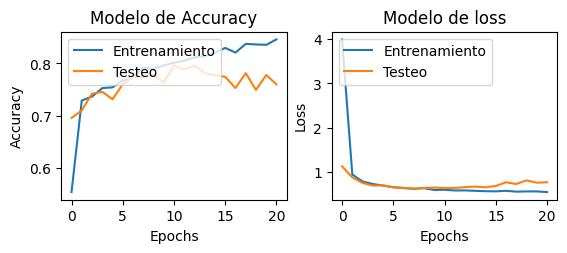

10/10 [==============================] - 1s 130ms/step


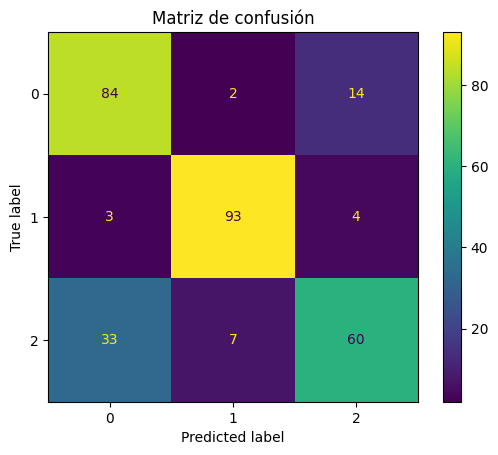

10/10 [==============================] - 2s 162ms/step


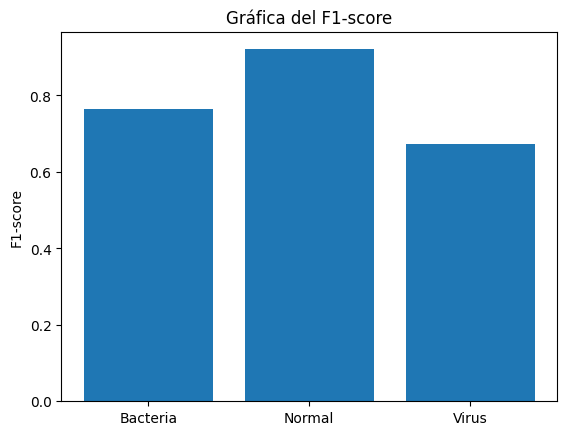

10/10 [==============================] - 2s 201ms/step


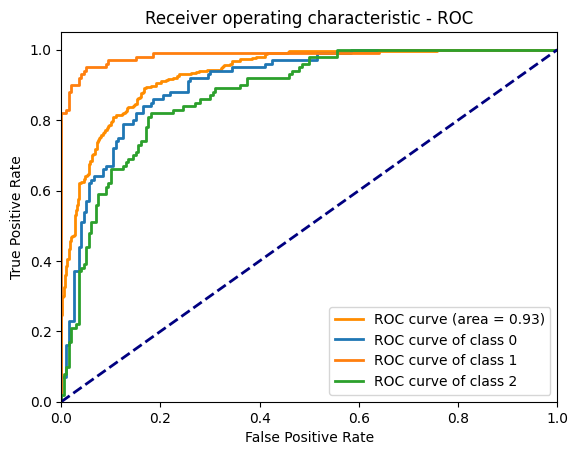

In [ ]:
# GRÁFICO DE ACCURACY
plt.subplot(2, 2, 1)
plt.plot(firstTraining.history['accuracy'])
plt.plot(firstTraining.history['val_accuracy'])
plt.title("Modelo de Accuracy")
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Entrenamiento', 'Testeo'], loc='upper left')

#-------------------------------------------------------------------------------

# GRÁFICO DE LOSS
plt.subplot(2, 2, 2)
plt.plot(firstTraining.history['loss'])
plt.plot(firstTraining.history['val_loss'])
plt.title("Modelo de loss")
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Entrenamiento', 'Testeo'], loc='upper left')
plt.show()

#-------------------------------------------------------------------------------

# GRÁFICO DE MATRIZ DE CONFUSIÓN
y_pred_CM = gonodactylus_simithii.predict(X_test)
result = confusion_matrix(y_test, y_pred_CM.argmax(axis=1))
disp = ConfusionMatrixDisplay(result)
disp.plot()
plt.title("Matriz de confusión")
plt.show()

#-------------------------------------------------------------------------------

#GRÁFICO DE F1

y_pred_F1 = gonodactylus_simithii.predict(X_test)
y_pred_F1 = np.argmax(y_pred_F1, axis=1)
report = classification_report(y_test, y_pred_F1, output_dict=True)

# Obtener las métricas de interés
f1_score = [report[str(i)]['f1-score'] for i in range(3)]

fig, ax = plt.subplots()
ax.bar(range(3), f1_score)
ax.set_xticks(range(3))
ax.set_xticklabels(['Bacteria', 'Normal', 'Virus'])
ax.set_ylabel('F1-score')
ax.set_title('Gráfica del F1-score')
plt.show()

#-------------------------------------------------------------------------------

#GRÁFICO DE ROC AUC
y_pred_ROCAUC = gonodactylus_simithii.predict(X_test)
y_test_binario = to_categorical(y_test)

# Calcula la curva ROC para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_binario[:, i], y_pred_ROCAUC[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calcula la curva ROC micro
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binario.ravel(), y_pred_ROCAUC.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Grafica la curva ROC
plt.figure()
lw = 2
plt.plot(fpr["micro"], tpr["micro"], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc["micro"])
for i in range(3):
    plt.plot(fpr[i], tpr[i], lw=lw,
             label="ROC curve of class {}".format(i))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic - ROC')
plt.legend(loc="lower right")
plt.show()

In [ ]:
loss, acc = gonodactylus_simithii.evaluate(X_test, y_test, verbose=1)
print("The loss is: {0}, and the accuracy is: {1}".format(loss, acc))

10/10 [==============================] - 1s 24ms/step - loss: 0.6241 - accuracy: 0.7833
The loss is: 0.6240734457969666, and the accuracy is: 0.7833333611488342


In [ ]:
extractor = tf.keras.applications.VGG16(weights='imagenet',
                                                include_top=False,
                                                input_shape=(150, 150, 3))

for layer in extractor.layers:
    layer.trainable = False

x = extractor.output
x = Flatten()(x)
x = Dense(512, activation='relu', kernel_regularizer= tf.keras.regularizers.L2(0.001))(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu', kernel_regularizer= tf.keras.regularizers.L2(0.001))(x)
x = Dropout(0.5)(x)
output = Dense(3, activation='softmax')(x)

transferLearning_model = Model(inputs=extractor.input, outputs=output)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
transferLearning_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
SecondTraining = transferLearning_model.fit(
    X_train, y_train,
    epochs=350,
    batch_size=64,
    validation_data=(X_val, y_val),
    verbose=1,
    callbacks=[best_callback, stopping_callback]
)

Epoch 1/350
61/61 [==============================] - ETA: 0s - loss: 0.8582 - accuracy: 0.6074
Epoch 1: val_accuracy did not improve from 0.79928
61/61 [==============================] - 22s 243ms/step - loss: 0.8582 - accuracy: 0.6074 - val_loss: 0.5271 - val_accuracy: 0.7670
Epoch 2/350
61/61 [==============================] - ETA: 0s - loss: 0.5927 - accuracy: 0.7377
Epoch 2: val_accuracy did not improve from 0.79928
61/61 [==============================] - 8s 135ms/step - loss: 0.5927 - accuracy: 0.7377 - val_loss: 0.5033 - val_accuracy: 0.7706
Epoch 3/350
61/61 [==============================] - ETA: 0s - loss: 0.5677 - accuracy: 0.7464
Epoch 3: val_accuracy did not improve from 0.79928
61/61 [==============================] - 8s 138ms/step - loss: 0.5677 - accuracy: 0.7464 - val_loss: 0.4944 - val_accuracy: 0.7814
Epoch 4/350
61/61 [==============================] - ETA: 0s - loss: 0.5284 - accuracy: 0.7697
Epoch 4: val_accuracy did not improve from 0.79928
61/61 [===============

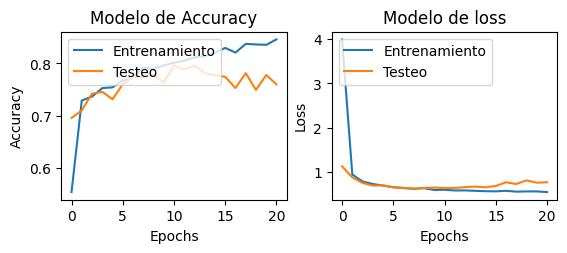

10/10 [==============================] - 1s 130ms/step


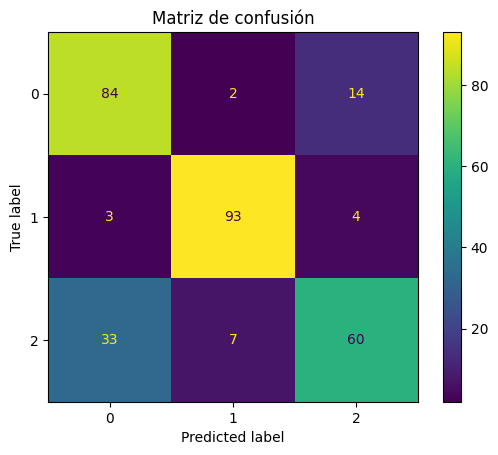

10/10 [==============================] - 2s 162ms/step


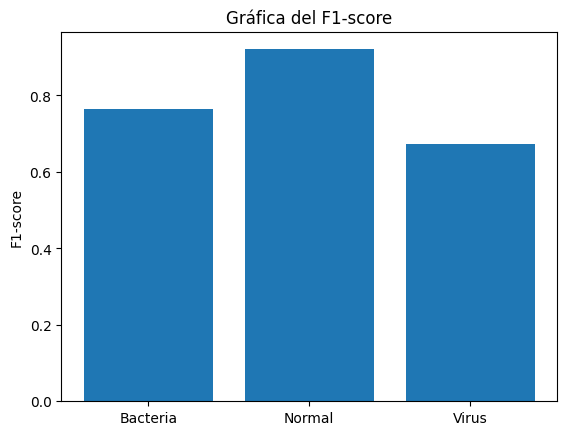

10/10 [==============================] - 2s 201ms/step


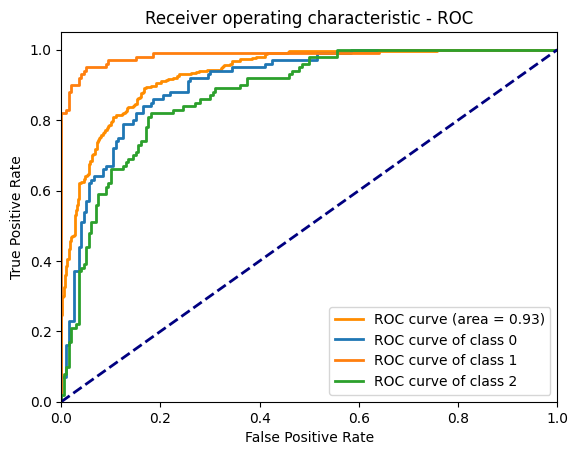

In [ ]:
# GRÁFICO DE ACCURACY
plt.subplot(2, 2, 1)
plt.plot(SecondTraining.history['accuracy'])
plt.plot(SecondTraining.history['val_accuracy'])
plt.title("Modelo de Accuracy")
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Entrenamiento', 'Testeo'], loc='upper left')

#-------------------------------------------------------------------------------

# GRÁFICO DE LOSS
plt.subplot(2, 2, 2)
plt.plot(SecondTraining.history['loss'])
plt.plot(SecondTraining.history['val_loss'])
plt.title("Modelo de loss")
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Entrenamiento', 'Testeo'], loc='upper left')
plt.show()

#-------------------------------------------------------------------------------

# GRÁFICO DE MATRIZ DE CONFUSIÓN
y_pred_CM2 = SecondTraining.predict(X_test)
result2 = confusion_matrix(y_test, y_pred_CM.argmax(axis=1))
disp2 = ConfusionMatrixDisplay(result)
disp2.plot()
plt.title("Matriz de confusión")
plt.show()

#-------------------------------------------------------------------------------

#GRÁFICO DE F1

y_pred_F1_2 = SecondTraining.predict(X_test)
y_pred_F1_2 = np.argmax(y_pred_F1_2, axis=1)
report2 = classification_report(y_test, y_pred_F1_2, output_dict=True)

# Obtener las métricas de interés
f1_score2 = [report[str(i)]['f1-score'] for i in range(3)]

fig2, ax2 = plt.subplots()
ax.bar(range(3), f1_score2)
ax.set_xticks(range(3))
ax.set_xticklabels(['Bacteria', 'Normal', 'Virus'])
ax.set_ylabel('F1-score')
ax.set_title('Gráfica del F1-score')
plt.show()

#-------------------------------------------------------------------------------

#GRÁFICO DE ROC AUC
y_pred_ROCAUC2 = SecondTraining.predict(X_test)
y_test_binario2 = to_categorical(y_test)

# Calcula la curva ROC para cada clase
fpr2 = dict()
tpr2 = dict()
roc_auc2 = dict()
for i in range(3):
    fpr2[i], tpr2[i], _ = roc_curve(y_test_binario2[:, i], y_pred_ROCAUC2[:, i])
    roc_auc2[i] = auc(fpr2[i], tpr2[i])

# Calcula la curva ROC micro
fpr2["micro"], tpr2["micro"], _ = roc_curve(y_test_binario2.ravel(), y_pred_ROCAUC2.ravel())
roc_auc2["micro"] = auc(fpr2["micro"], tpr2["micro"])

# Grafica la curva ROC
plt.figure()
lw2 = 2
plt.plot(fpr2["micro"], tpr2["micro"], color='darkorange',
         lw=lw2, label='ROC curve (area = %0.2f)' % roc_auc2["micro"])
for i in range(3):
    plt.plot(fpr2[i], tpr2[i], lw=lw2,
             label="ROC curve of class {}".format(i))

plt.plot([0, 1], [0, 1], color='navy', lw=lw2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic - ROC')
plt.legend(loc="lower right")
plt.show()

"loss: 0.4548 - accuracy: 0.8100": Aquí se muestran las métricas de pérdida y precisión (accuracy) en el conjunto de prueba. Estos valores son los resultados de la evaluación del modelo en los datos de prueba.

"loss: 0.4548" indica que la pérdida promedio en el conjunto de prueba es aproximadamente 0.4548. La pérdida es una medida de qué tan bien se están haciendo las predicciones del modelo, y en general, se busca que sea lo más bajo posible.
"accuracy: 0.8100" indica que la precisión promedio en el conjunto de prueba es aproximadamente 0.8100 o 81%. Esto significa que el modelo acertó en alrededor del 81% de las predicciones en el conjunto de prueba. La precisión es una medida de qué tan bien el modelo clasifica los datos.
En resumen, el resultado muestra el progreso de la evaluación de los lotes, el tiempo que tomó y las métricas de pérdida y precisión en el conjunto de prueba. En este caso, el modelo obtuvo una pérdida de aproximadamente 0.4548 y una precisión de aproximadamente 81% en el conjunto de prueba.

In [ ]:
loss2, acc2 = transferLearning_model.evaluate(X_test, y_test, verbose=1)
print("The loss is: {0}, and the accuracy is: {1}".format(loss2, acc2))

10/10 [==============================] - 4s 190ms/step - loss: 0.4548 - accuracy: 0.8100
The loss is: 0.4547780454158783, and the accuracy is: 0.8100000023841858
